In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import impyute as impy
import pmdarima as pm

from pythainlp.util import thai_strftime
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from   matplotlib.ticker import FormatStrFormatter, ScalarFormatter

from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, VAR, VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tools.eval_measures import rmse, aic, bic
from statsmodels.tools.eval_measures import meanabs as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
import joblib
warnings.filterwarnings("ignore")

# import locale
# locale.setlocale(locale.LC_ALL, 'th_TH')
# locale.setlocale(locale.LC_ALL, 'en_US')
# joblib.dump(arima_hml, 'arima_hml.pkl')

In [2]:
monthTH = pd.read_excel('../data/month.xlsx')
month_map = dict(zip(monthTH.short_th, monthTH.num))

In [3]:
def read_price(name):
    path = f'../data/{name}.xls'
    df = (pd.read_excel(path, sheet_name = 'price', skiprows = 2, na_values = '-')
          .melt(id_vars = 'ปี', var_name = 'month')
          .rename(columns = {'ปี':'year'})
          .assign(year = lambda x: x.year-543)
          .assign(month = lambda x: x.month.str.strip().map(month_map))
          .assign(value = lambda x: pd.to_numeric(x.value, errors='coerce'))
          .assign(date = lambda x: pd.to_datetime(
              '1' + '/' + x.month.astype(str) + '/' + x.year.astype(str),
              dayfirst = True,))
          .query('year<2020 & ~value.isna()')
          .set_index('date')
          .sort_index()
          .asfreq(freq='MS')
          .drop(columns=['year', 'month'])
          .interpolate(method='time')
       )
    return df

In [5]:
hml = dict(data = read_price('hml'), abb = 'hml', shortname = 'ข้าวหอมมะลิ', fullname = 'ราคาข้าวเปลือกหอมมะลิที่เกษตรกรขายได้ ณ ไร่นา')
wht = dict(data = read_price('wht'), abb = 'wht', shortname = 'ข้าวเจ้าขาว', fullname = 'ราคาข้าวเปลือกเจ้าขาวที่เกษตรกรขายได้ ณ ไร่นา')
glu = dict(data = read_price('glu'), abb = 'glu', shortname = 'ข้าวเหนียว', fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาวที่เกษตรกรขายได้ ณ ไร่นา')
rices = [hml, wht, glu]

In [8]:
pledg_idx = pd.date_range('2011-10', '2014-2', freq='MS')
exo = pd.DataFrame(index = wht['data'].index)
exo['pledge'] = 0
exo.loc['2011-10':'2014-2'] = 1

In [6]:
def split_train_test(dic, prop_test = 0.2):
    data = dic['data']
    n_train = int((1-prop_test)*data.shape[0])
    dic['train'] = data[:n_train]
    dic['test']  = data[n_train:]

def get_n(df, n_test):
    N = df['data'].shape[0]
    if n_test == None:
        n_train = df['train'].shape[0]
        n_test = N - n_train
    else:
        n_train = N - n_test
    return N, n_train, n_test

def online_arima(ser, prop_test = 0.2):
    model = []
    N = ser.shape[0]
    n_train = int((1-prop_test)*N)
    for i in np.arange(n_train, N):
        res = pm.auto_arima(ser.value[:i],
                            start_p=1, start_q=1,
                            max_p=6, max_q=6, m=12,
                            start_P=0, information_criterion='aicc',
                            seasonal=True,
                           )
        model.append(res)
    return model

def perdict(ser, model, n_predict=6):
    N = ser.shape[0]
    n_test = len(model)
    predict = np.empty((n_test, n_predict))
    for i in range(n_test):
        predict[i] = arima_hml[i].predict(n_periods=n_predict)
    return pd.DataFrame(predict, columns=[f'pred{i}' for i in range(1,7)], index=ser.index[-n_test:])

def thai_year(x, pos):
    date = thai_strftime(mdates.num2date(x), '%Y')
    return f'{date}'

In [7]:
for rice in rices:
    split_train_test(rice)

# Visualization and Decomposition

In [29]:
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH SarabunPSK')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(10,6), dpi=200)

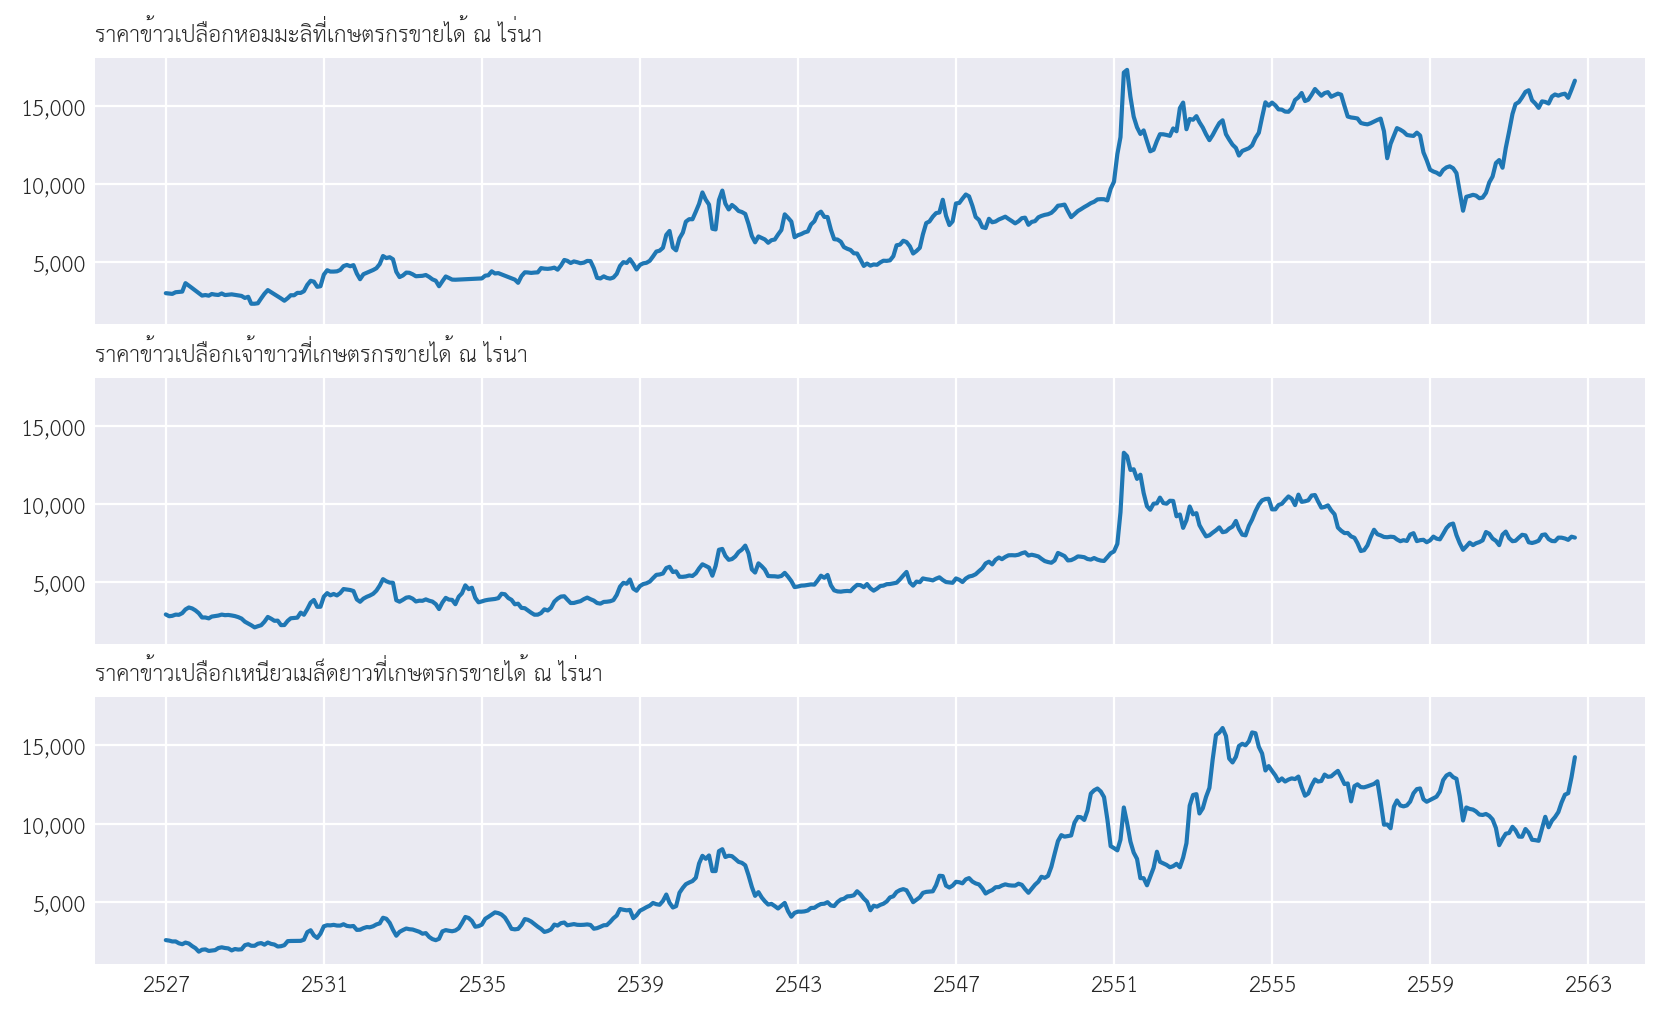

In [31]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 6))
# fig.subplots_adjust(hspace=1)
for i, rice in enumerate(rices):
    ax[i].plot(rice['data'].index, rice['data'].value)
    ax[i].set_title(rice['fullname'], loc='left')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(thai_year))
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

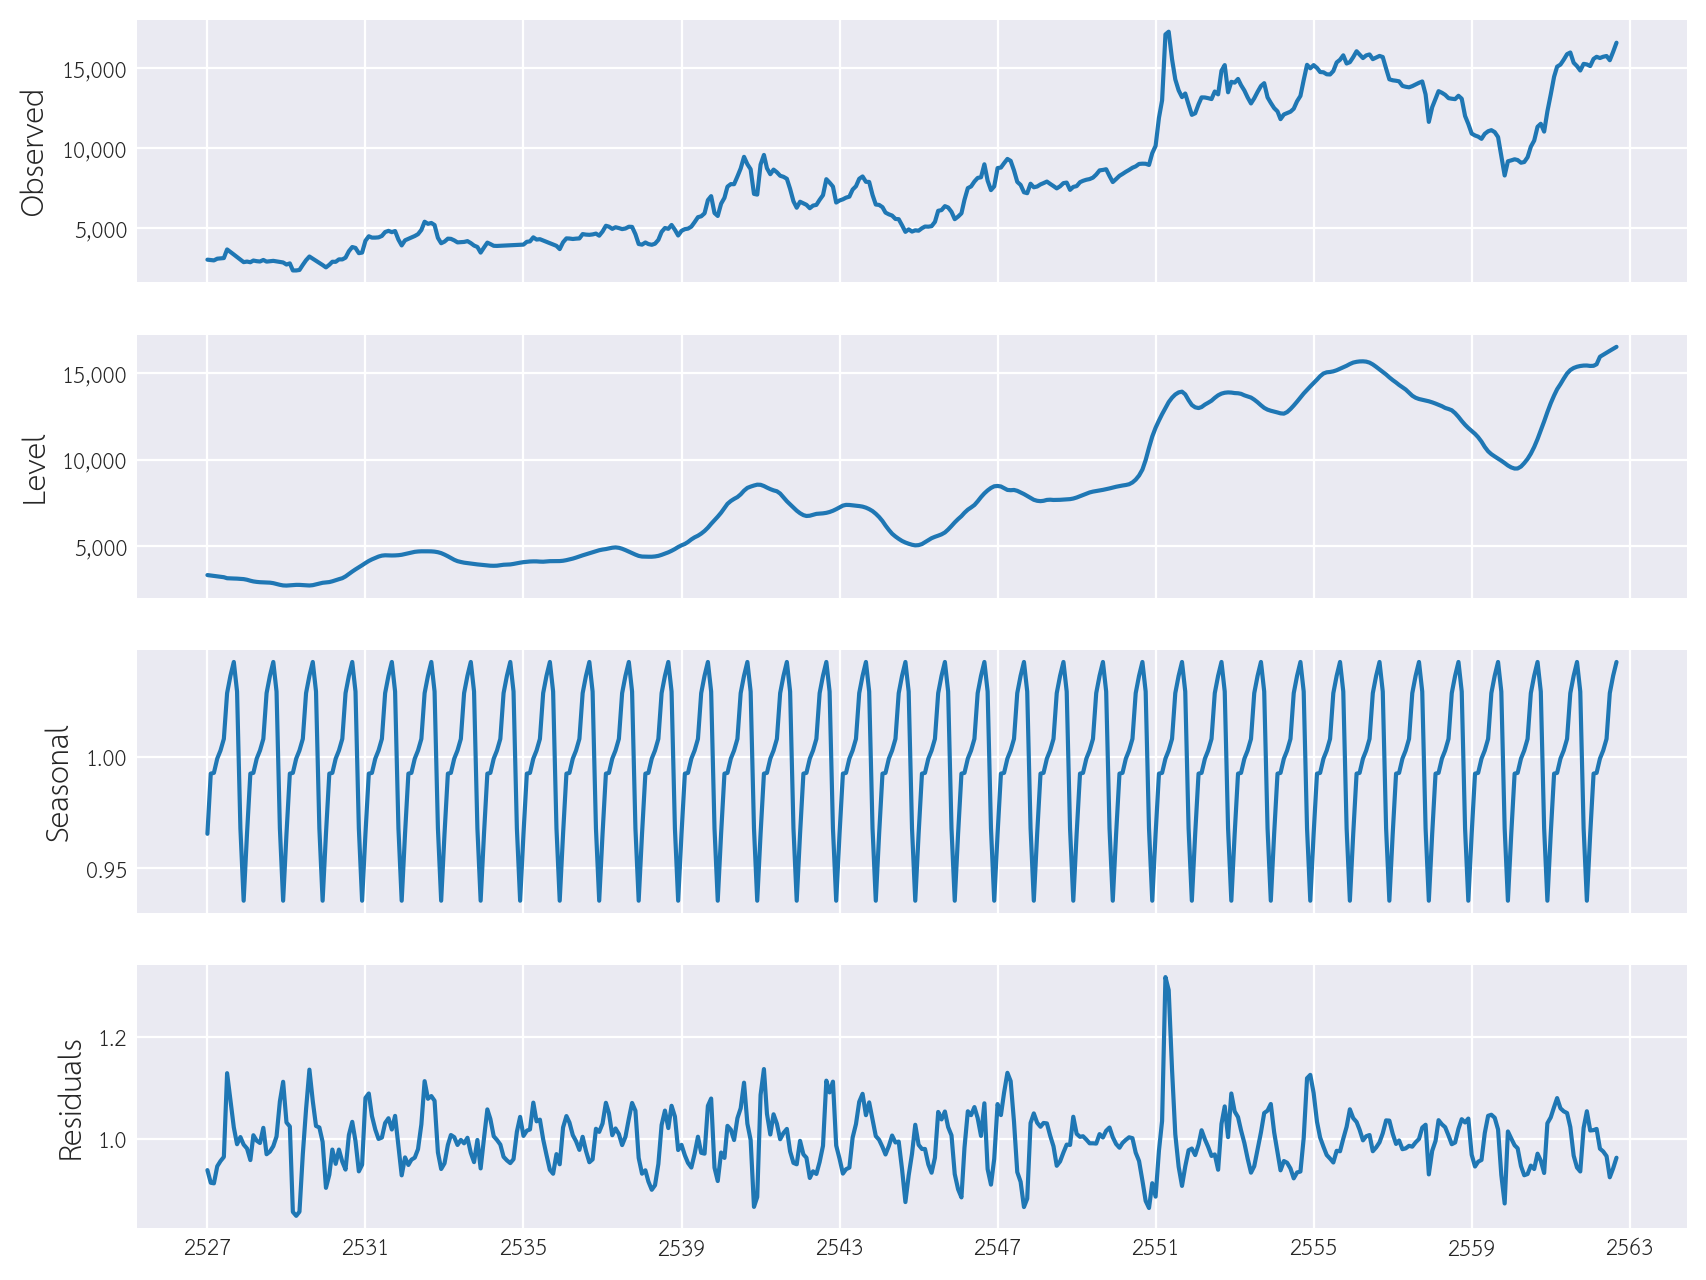

In [39]:
decom_mul = seasonal_decompose(hml['data'].value,
                               model='multiplicative',
                               extrapolate_trend='freq',
                              )

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,8))
ax[0].plot(decom_mul.observed.index, decom_mul.observed)
ax[1].plot(decom_mul.trend)
ax[2].plot(decom_mul.seasonal)
ax[3].plot(decom_mul.resid)
for ix, i in enumerate(['Observed', 'Level', 'Seasonal', 'Residuals']):
    ax[ix].set(ylabel=i)
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(thai_year))
ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [ ]:
plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_acf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()


plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':300})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.price); axes[0, 0].set_title('Original Series')
plot_pacf(df.price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.price.diff().values); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(df.price.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.price.diff().diff().values); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(df.price.diff().diff().dropna().values, ax=axes[2, 1])

plt.show()

# Stationary Test

In [11]:
def test_stationary(df, col='value'):
    name = df['shortname']
    col_names = ['name', 'level', 'adf_stat', 'adf_pval', 'kpss_stat', 'kpss_pval']
    level = df['data'][col]
    diff1 = df['data'][col].diff()[1:]

    result = []
    result.append([name, 'level', *adfuller(level)[:2], *kpss(level)[:2]])
    result.append([name, 'diff1', *adfuller(diff1)[:2], *kpss(diff1)[:2]])

    return pd.DataFrame(result, columns=col_names).set_index(['name', 'level']).round(4)

In [12]:
res_stationary = pd.DataFrame()
for rice in rices:
    res_stationary = res_stationary.append(test_stationary(rice))
res_stationary

adf_stat  adf_pval  kpss_stat  kpss_pval
name level                                          
hml  level   -0.9294    0.7781     2.0721       0.01
     diff1  -13.8104    0.0000     0.0558       0.10
wht  level   -1.5430    0.5121     1.9118       0.01
     diff1   -6.0760    0.0000     0.0467       0.10
glu  level   -0.8153    0.8146     2.0079       0.01
     diff1   -5.7040    0.0000     0.0433       0.10

# Exponential Smoothing

In [13]:
def hws(df, n_train):
    return ExponentialSmoothing(df['data'][:n_train],
                                trend='add', damped=True,
                                seasonal='mul', seasonal_periods=12
                               ).fit()

def rolling_hws(df, n_test=None, n_fcast=6):
    N, n_train, n_test = get_n(df, n_test)
    
    fcast = np.empty((n_test, n_fcast))
    for i in range(n_test):
        fcast[i] = hws(df, n_train+i).forecast(n_fcast)

    return pd.DataFrame(fcast,
                        columns=[f'fcast{i}' for i in range(1,n_fcast+1)],
                        index=df['data'].index[-n_test:])

In [14]:
hml['fcast_hws'] = rolling_hws(hml)

In [114]:
def plot_fcast(df, method='hws'):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df['train'], color='black', alpha=0.4)
    ax.plot(df['test'], color='royalblue')
    ax.plot(df[f'fcast_{method}'].fcast1.shift(1), color='crimson', ls='dashed')
    ax.set_xlim([datetime.date(2000, 1, 1), datetime.date(2019, 9, 1)])
    ax.set_ylim(0)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    sns.despine(bottom=False, left=True, ax=ax)

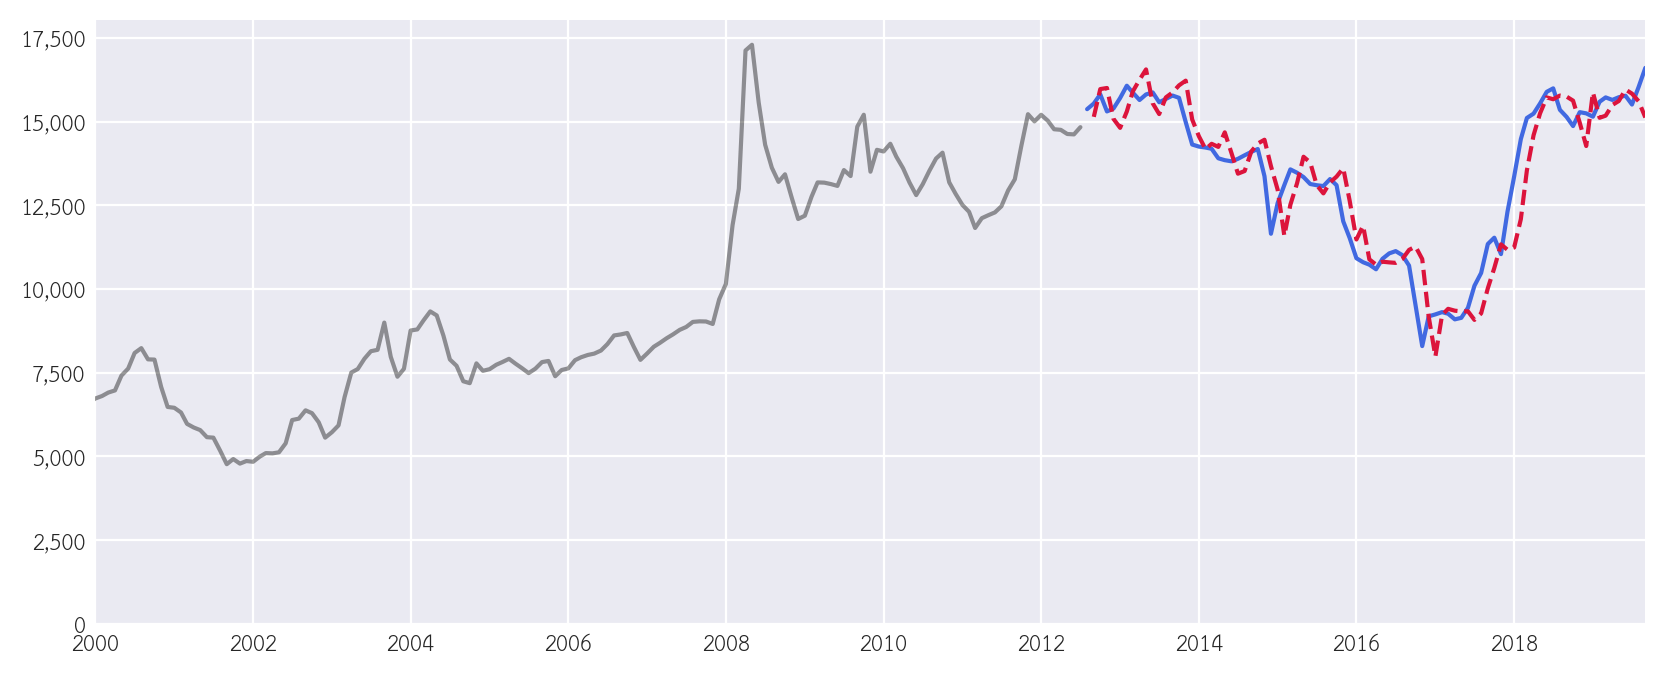

In [115]:
plot_fcast(hml, method='hws')

# Arima

In [218]:
def arima(df, n_train, use_exo=True):
    return pm.auto_arima(df['data'][:n_train],
                         exogenous=exo.iloc[:n_train] if use_exo==True else None,
                         start_p=0, start_q=0,
                         max_p=6, max_q=6,
                         start_P=0, start_Q=0,
                         m=12, seasonal=True,
                         d=1, D=0,
                         information_criterion='aicc',
                        )

In [117]:
def arima(df, n_train, use_exo=True):
    return pm.auto_arima(df['data'][:n_train],
                         exogenous=exo.iloc[:n_train] if use_exo==True else None,
                         m=12, seasonal=True,
                         d=1, D=0,
                         start_p=0, start_q=0,
                         max_p=6, max_q=6,
                         start_P=0, start_Q=0,
                         information_criterion='aicc',
                        )

def rolling_arima(df, n_test=None, n_fcast=6, reselect_orders=False):
    N, n_train, n_test = get_n(df, n_test)
    
    # กรณี p,q,P,Q sarima ถูกกำหนดโดย training data แล้ว fix
    if reselect_orders == False:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        
        # estimate arima โดยใช้ train dataset
        model = arima(df, n_train)
        
        # forecast
        fcast[0] = model.predict(n_fcast)
        orders.append(str(model.order + model.seasonal_order))
        
        # refit arima model โดยใช้ update method กับข้อมูลใหม่
        for i in range(1, n_test):
            model = model.update(df['data'][n_train+i:n_train+i+1])
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))
            
    # กรณีหา p,q,P,Q ทุกครั้ง
    else:
        # สร้าง empty container สำหรับ forecast value และ orders ของ arima
        fcast = np.empty((n_test, n_fcast))
        orders = []
        for i in range(n_test):
            # estimate arima โดยใช้ข้อมูลจากอดีตถึงปัจจุบัน
            model = arima(df, n_train+i)
            fcast[i] = model.predict(n_fcast)
            orders.append(str(model.order + model.seasonal_order))        
    
    res = pd.DataFrame(fcast,
                       columns=[f'fcast{i}' for i in range(1,n_fcast+1)],
                       index=df['data'].index[-n_test:])
    res['orders'] = orders
    return res

In [111]:
hml['fcast_arima'] = rolling_arima(hml)

In [118]:
hml['fcast_arima_re'] = rolling_arima(hml, reselect_orders=True)

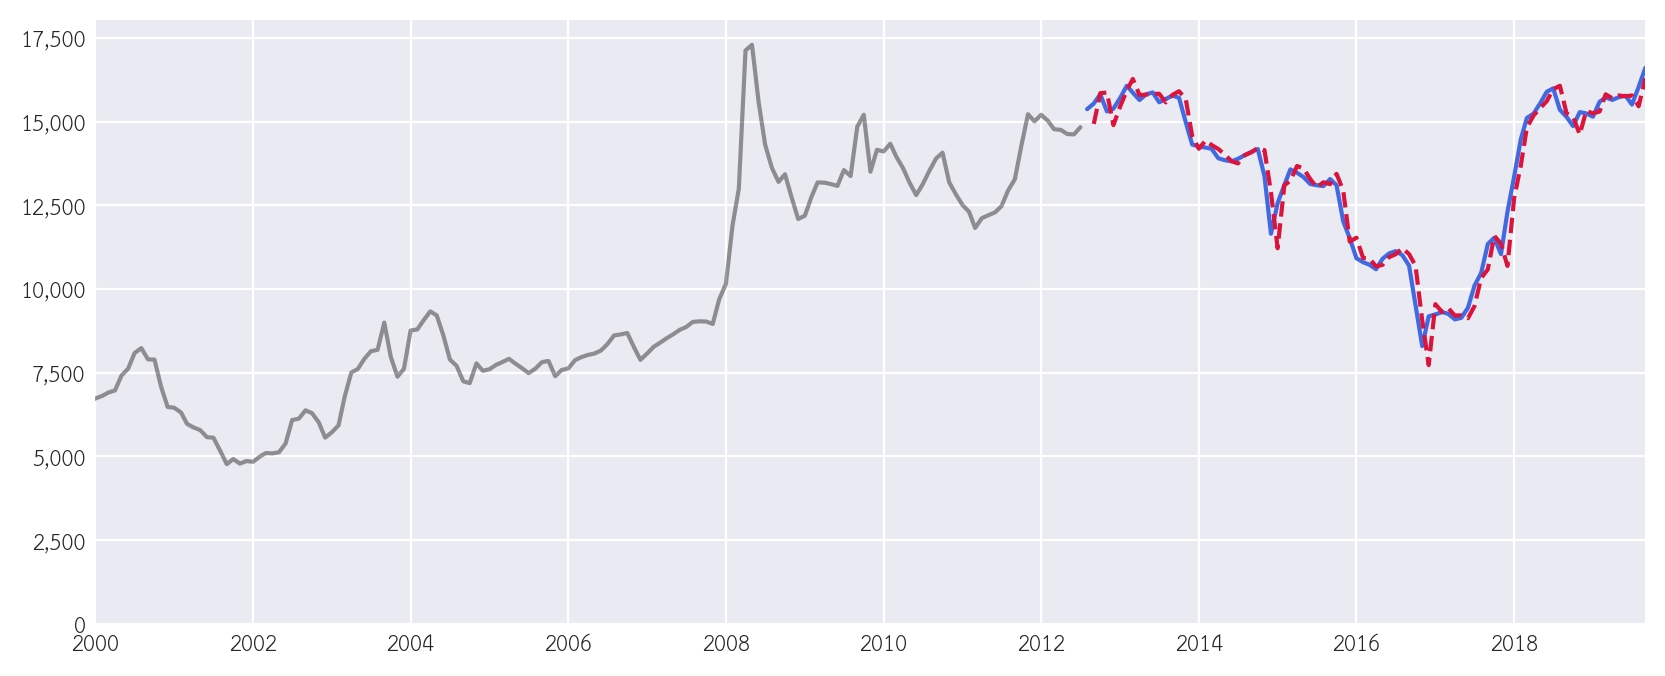

In [172]:
plot_fcast(hml, method='arima')

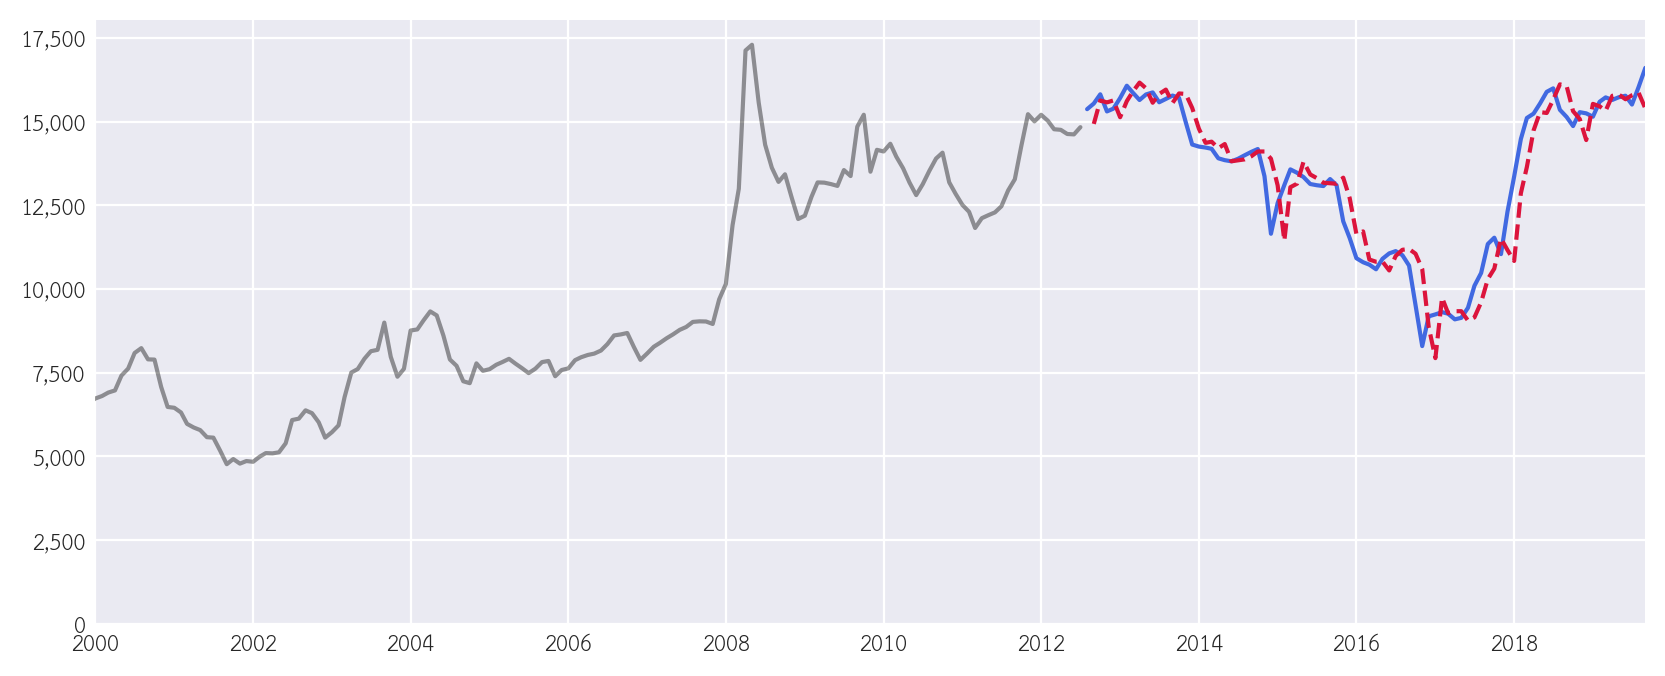

In [173]:
plot_fcast(hml, method='arima_re')

In [165]:
def eval_fcast(df, method='hws', metrics=MSE, n_forecast=6):
    N, n_train, n_test = get_n(df, None)
    data = df['data'].join(df[f'fcast_{method}'])
    res = []
    for i in range(1, n_forecast+1):
        _ = metrics(data['value'][n_train+i : N-n_forecast],
                    data[f'fcast{i}'].shift(i)[n_train+i : N-n_forecast]
                   )
#         res.append(_)
#     return np.array(res).sum()
    return _

In [ ]:
def forecast_accuracy(forecast, actual):
    diff = forecast-actual
    mape = np.mean( np.abs(diff)/np.abs(actual) )
    rmse = np.mean( diff**2 ) **0.5
    return ({'mape': mape,
             'rmse': rmse,
            })

In [166]:
eval_fcast(hml, method='hws')

3107632.5107814297

In [167]:
eval_fcast(hml, method='arima')

2639764.0116808875

In [166]:
eval_fcast(hml, method='hws')

3107632.5107814297

In [169]:
eval_fcast(hml, method='arima_re')

3223393.895564191

In [123]:
hml['data'].index[20:30]

DatetimeIndex(['1985-09-01', '1985-10-01', '1985-11-01', '1985-12-01',
               '1986-01-01', '1986-02-01', '1986-03-01', '1986-04-01',
               '1986-05-01', '1986-06-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

In [125]:
hml['data'].loc[hml['data'].index[20:30]]

,value
date,
1985-09-01,2950.000000
1985-10-01,2917.032967
1985-11-01,2882.967033
1985-12-01,2850.000000
1986-01-01,2721.000000
1986-02-01,2792.000000
1986-03-01,2350.000000
1986-04-01,2350.000000
1986-05-01,2380.000000


In [166]:
def lstm_prepossesing(df):
    n_train = int(df['data'].shape[0]*0.8)
    X = pd.DataFrame(index = df['data'].index)
    for i in range(1, 25):
         X[f'feat{i}'] = df['data'].shift(i)
    test_X = X[n_train:]
    test_y = df['data'][n_train:].values
    test_X = test_X.values.reshape(test_X.shape[0], 1, test_X.shape[1])
    train_X = X[:n_train].dropna()
    train_y = df['data'].loc[train_X.index].values
    train_X = train_X.values.reshape(train_X.shape[0], 1, train_X.shape[1])
#     train_y = y.values
    
    return train_X, train_y, test_X, test_y

In [167]:
train_X, train_y, test_X, test_y = lstm_prepossesing(hml)

# LSTM

Train on 319 samples, validate on 86 samples
Epoch 1/100
 - 0s - loss: 7182.0110 - val_loss: 13433.6907
Epoch 2/100
 - 0s - loss: 7181.6414 - val_loss: 13433.4980
Epoch 3/100
 - 0s - loss: 7181.4666 - val_loss: 13433.3463
Epoch 4/100
 - 0s - loss: 7181.2641 - val_loss: 13433.1844
Epoch 5/100
 - 0s - loss: 7181.1218 - val_loss: 13433.0889
Epoch 6/100
 - 0s - loss: 7180.9979 - val_loss: 13432.9868
Epoch 7/100
 - 0s - loss: 7180.9132 - val_loss: 13432.8788
Epoch 8/100
 - 0s - loss: 7180.8123 - val_loss: 13432.6725
Epoch 9/100
 - 0s - loss: 7180.7114 - val_loss: 13432.6199
Epoch 10/100
 - 0s - loss: 7180.6470 - val_loss: 13432.5700
Epoch 11/100
 - 0s - loss: 7180.5910 - val_loss: 13432.5172
Epoch 12/100
 - 0s - loss: 7180.5336 - val_loss: 13432.4681
Epoch 13/100
 - 0s - loss: 7180.4818 - val_loss: 13432.4147
Epoch 14/100
 - 0s - loss: 7180.4298 - val_loss: 13432.3621
Epoch 15/100
 - 0s - loss: 7180.3781 - val_loss: 13432.3122
Epoch 16/100
 - 0s - loss: 7180.3266 - val_loss: 13432.2594
Epoc

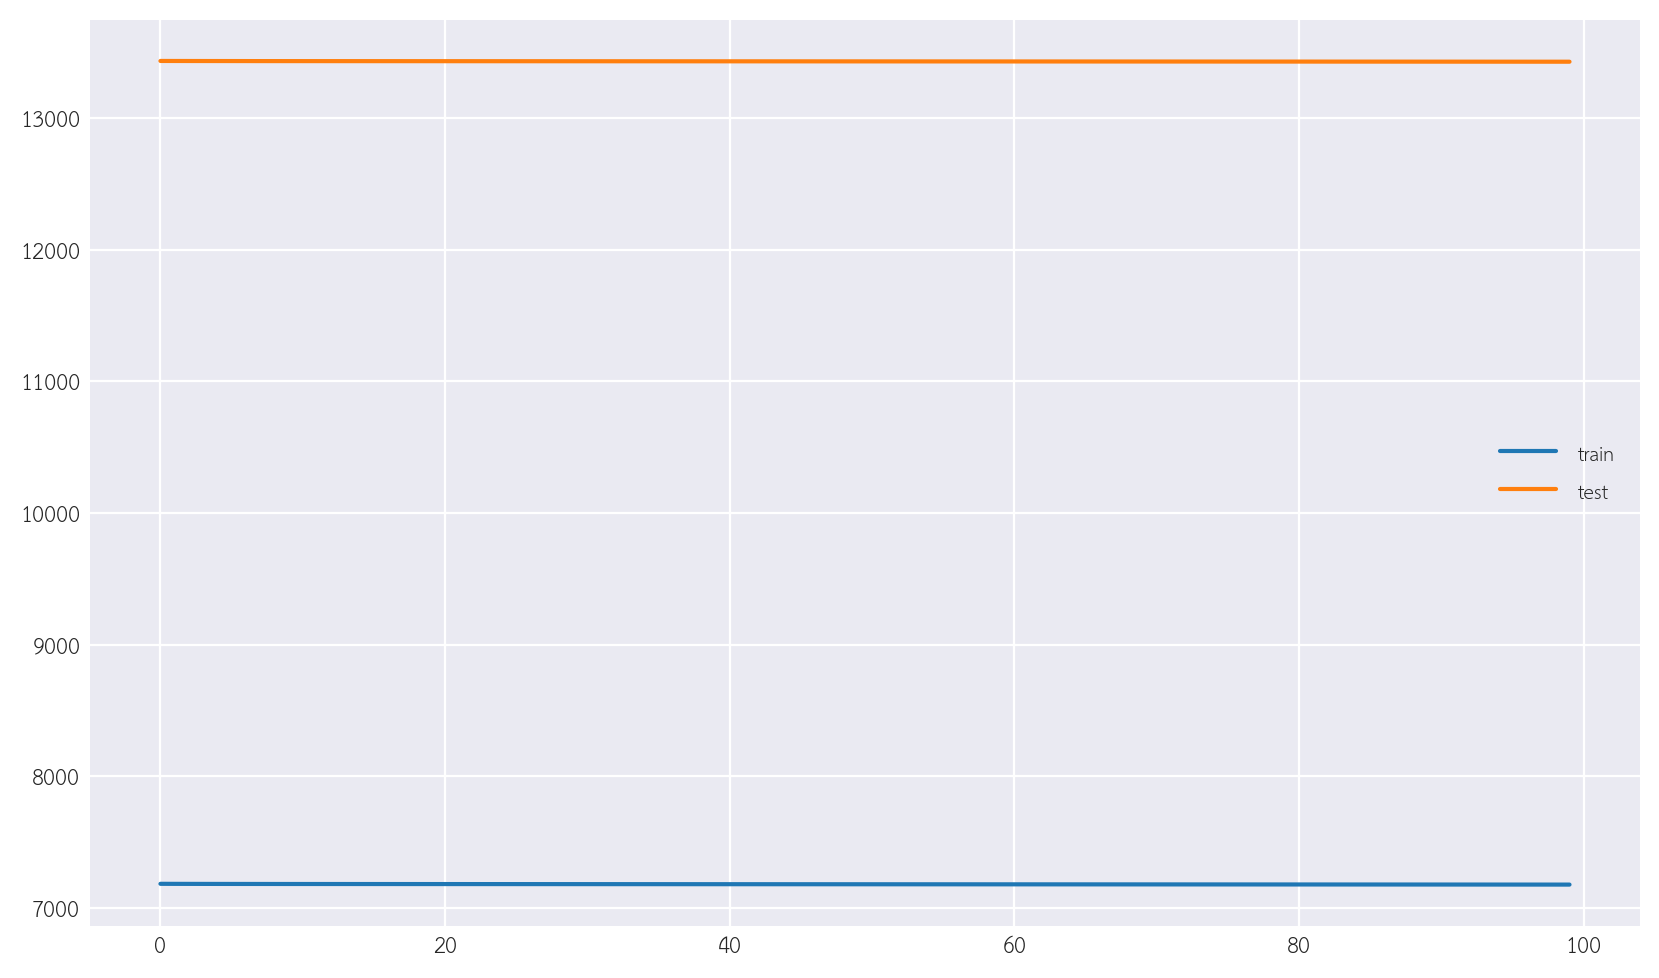

In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_hml = lstm_prepossesing(hml)

# สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(50) และ shape ของข้อมูล input(#rows x #features)
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (6) 
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# train โมเดล และเก็บ log
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# # พล็อตค่า train&test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [169]:
yhat = model.predict(test_X)
yhat

array([[6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
       [6.4123955],
